In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import os
import glob
import dask.array as da
import datetime as dt

In [2]:
# ind=(mm==(im-1)%12)|(mm==im)|(mm==(im+1)%12) # 3 month groups running mean

In [3]:
ptile=90
years = [1991, 2020]
il=0
def sstfile(lead,years):
    return f'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW/newHindcastMonthly/sst_HC_l{il}_{years[0]}_{years[1]}.nc'
def anomfile(mod,lead,years,detr):
    detrstr='_detr' if detr=='detr' else ''
    return f"/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW/newHindcastMonthly/sstAnom{detrstr}_HC{mod}_l{lead}_{years[0]}_{years[1]}.nc"

In [4]:
f=xr.open_dataset(sstfile(il,years))

In [5]:
# ensemble members 1-20 = GEM5.2-NEMO
# ensemble members 21-40 = CanESM5
ens=dict(GN=f.sst.isel(M=slice(0,20)),
         C5=f.sst.isel(M=slice(20,40)))
modkeys=list(ens.keys())

In [6]:
nt,nm,ny,nx=np.shape(ens['GN']) # both models have same number of ensemble members
nt,nm,ny,nx

(360, 20, 180, 360)

In [7]:
Emean={imod: ens[imod].mean(dim='M',keepdims=True) for imod in modkeys} # ensemble mean for each model

In [8]:
clim={imod:da.zeros((12,1,ny,nx)) for imod in modkeys} # initialize climatology arrays

In [9]:
print(dt.datetime.now())
# define climatologies and load in memory
for imod in modkeys:
    for im in range(0,12):
        clim[imod][im,...]=Emean[imod].isel(S=slice(im,-1,12)).mean(dim='S').compute()
        print(dt.datetime.now())

2024-08-14 22:36:31.164134
2024-08-14 22:36:31.170314
2024-08-14 22:36:31.175628
2024-08-14 22:36:31.180609
2024-08-14 22:36:31.185582
2024-08-14 22:36:31.190313
2024-08-14 22:36:31.195051
2024-08-14 22:36:31.199731
2024-08-14 22:36:31.204579
2024-08-14 22:36:31.209206
2024-08-14 22:36:31.214027
2024-08-14 22:36:31.218680
2024-08-14 22:36:31.223279
2024-08-14 22:36:31.228349
2024-08-14 22:36:31.233346
2024-08-14 22:36:31.238305
2024-08-14 22:36:31.243099
2024-08-14 22:36:31.248059
2024-08-14 22:36:31.252838
2024-08-14 22:36:31.257632
2024-08-14 22:36:31.262458
2024-08-14 22:36:31.267383
2024-08-14 22:36:31.272140
2024-08-14 22:36:31.276955
2024-08-14 22:36:31.281492


In [10]:
clim[modkeys[0]]

dask.array<setitem, shape=(12, 1, 180, 360), dtype=float64, chunksize=(12, 1, 180, 360), chunktype=numpy.ndarray>

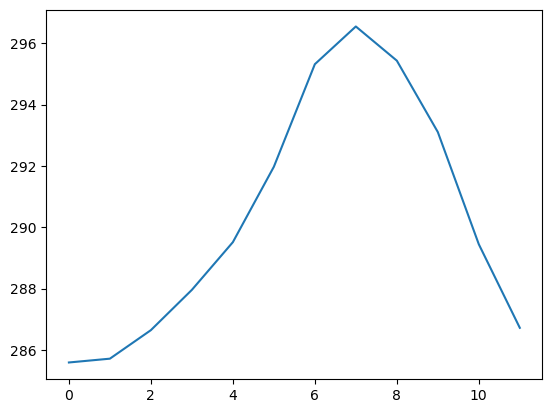

In [11]:
plt.plot(clim[modkeys[0]][:,0,120,100])

In [12]:
print(dt.datetime.now())
anom={(imod,'base'):ens[imod].data-da.tile(clim[imod],(int(nt/12),nm,1,1)) for imod in modkeys} # anomolies as dask array
print(dt.datetime.now())

2024-08-14 22:36:31.618281
2024-08-14 22:36:36.967735


In [13]:
anom[(modkeys[0],'base')]

dask.array<subtract, shape=(360, 20, 180, 360), dtype=float64, chunksize=(12, 1, 180, 360), chunktype=numpy.ndarray>

In [14]:
anom[(modkeys[0],'base')].shape

(360, 20, 180, 360)

In [15]:
GNanom=anom[(modkeys[0],'base')] # for testing
vec=GNanom[:,5,100,100]
vec

dask.array<getitem, shape=(360,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>

/home/ords/crd/ccrn/reo000/miniconda3/envs/py39dc2/lib/python3.9/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.polyfit` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


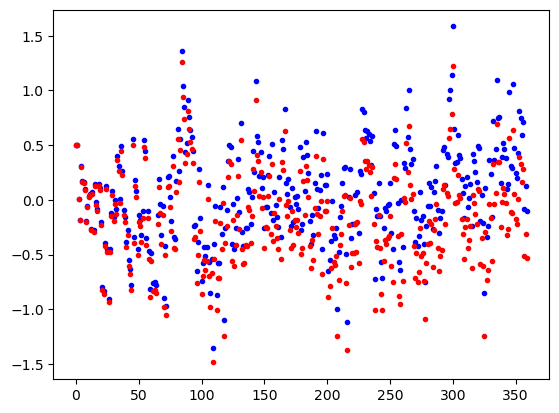

In [16]:
N=len(vec)
X=np.concatenate([np.ones((N,1)), np.expand_dims(np.arange(0,N),1)],1)
p=np.polyfit(np.arange(0,N),vec,1)
vec2=vec-p[0]*np.arange(0,N)
plt.plot(vec,'b.')
plt.plot(vec2,'r.')

In [17]:
def test(vec):
    return np.arange(0,len(vec))# for testing da.apply_along_axis behavior
testout=da.apply_along_axis(test,0,GNanom,shape=(GNanom.shape[0],))
testout[2,5,100,100].compute() # should be 2

2

In [18]:
def test(vec):
    return np.mean(vec)*np.ones((len(vec),))
testout=da.apply_along_axis(test,0,GNanom,shape=(GNanom.shape[0],))
np.max(np.abs(testout[3,5,100,100]-GNanom.mean(axis=0)[5,100,100])).compute() # should be 0

0.0

In [19]:
def _detrend_1d(vec):
    ii=~np.isnan(vec)
    x=np.arange(0,len(vec))
    if np.sum(ii)>0:
        p=np.polyfit(x[ii].flatten(),vec[ii].flatten(),1)
        return vec-p[0]*x
    else:
        return vec # in this case should be all NaNs

In [20]:
print(dt.datetime.now())
for imod in modkeys: # add detrended anomalies to anom dict
    anom[(imod,'detr')]=da.apply_along_axis(_detrend_1d,0,anom[(imod,'base')],shape=(anom[(imod,'base')].shape[0],),dtype=np.float64)
    print(dt.datetime.now())

2024-08-14 22:36:38.582354
2024-08-14 22:36:38.643213
2024-08-14 22:36:38.646515


In [21]:
print(dt.datetime.now())
akeys=list(anom.keys()) # list of all combinations of models with 'base' and 'detr'
# write anomaly files (to trigger computation and save intermediate step)
for ikey in akeys:
    mod=ikey[0]
    detr=ikey[1]
    f_out=anomfile(mod,il,years,detr)
    dsout=xr.Dataset(data_vars={'start_time':f.start_time,
                        'anom':(['S','M','Y','X'],anom[ikey])},
            coords=dict(lon=f.lon,lat=f.lat,M=ens[mod].M,S=f.S),)
    dsout.to_netcdf(f_out,mode='w')
    print(dt.datetime.now())

2024-08-14 22:36:38.651776
2024-08-14 22:36:43.479180
2024-08-14 22:36:45.552745
2024-08-14 22:39:21.456191
2024-08-14 22:41:56.394440


In [22]:
f.close()

In [23]:
print(dt.datetime.now())

2024-08-14 22:41:56.406906


In [24]:
f_out

'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW/newHindcastMonthly/sstAnom_detr_HCC5_l0_1991_2020.nc'

In [25]:
akeys

[('GN', 'base'), ('C5', 'base'), ('GN', 'detr'), ('C5', 'detr')]